# Линейная классификация

## Постановка задачи



Рассмотрим задачу классификации на два класса. Например, у нас есть данные о лабораторных мышах. Часть из них имеет нормальную массу тела, а часть — мыши с ожирением.

<img src ="https://ml.gan4x4.ru/msu/dev-2.1/L02/out/svm_mouse_example.png" width="800">

Итак:
1. У нас есть набор данных из $N$ объектов (мышей).
2. Для каждого из объектов (мышей) нам известно признаковое описание объекта в виде набора вещественных чисел (вес, длина от носа до кончика хвоста, возраст и т.д.). То есть объекту под номером $i$ соответствует вектор $\vec x_i$.
3. Также для каждого объекта нам известна истинная метка класса. Мы знаем, что объекту с признаковым описанием $\vec x_i$ соответствует метка класса $y_i$. Будем считать, что метки классов принимают значения:
$$y_i =
\begin{cases}
    1, & \text{для пухляшей}, \\
    0, & \text{для всех остальных}.
\end{cases}$$

Рассмотрим **одномерный пример**. У нас есть данные только по **массе мышей**. Часть из них определена как мыши с нормальной массой тела, а часть — как мыши с ожирением.

Попробуем отделить их друг от друга с использованием линейной регрессии и посмотрим на остатки.

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from matplotlib.colors import ListedColormap


custom_cmap = ListedColormap(["#B8E1EC", "#bea6ff", "#FEE7D0"])


def generate_data(total_len=40):
    x = np.hstack(
        [
            np.random.uniform(14, 21, total_len // 2),
            np.random.uniform(24, 33, total_len // 2),
        ]
    )
    y = np.hstack([np.zeros(total_len // 2), np.ones(total_len // 2)])
    return x, y

total_len = 100
np.random.seed(42)

x, y = generate_data(total_len=total_len)
x = x[:,  np.newaxis]
regressor = LinearRegression()
regressor.fit(x, y)
y_pred = regressor.predict(x)

x_model = np.linspace(14, 33, 300)
x_model = x_model[:,  np.newaxis]
y_model = regressor.predict(x_model)

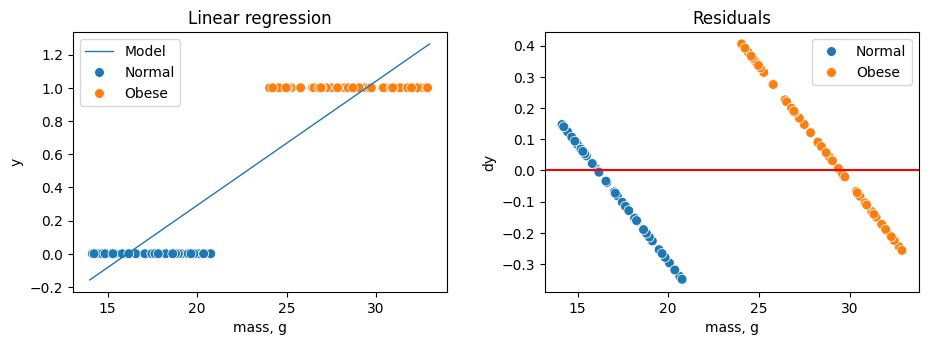

In [ ]:
def visual_1d_linear_model(x, y, y_pred, x_model, y_model, label):

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    fig.tight_layout(pad=4.0)

    axs[0].plot(
        x_model,
        y_model,
        label=label,
        linewidth=1,
    )

    axs[0].set(ylabel="y", xlabel="mass, g", title=label)
    sns.scatterplot(x=x[:, 0], y=y, hue=y, s=50, ax=axs[0])
    handles, labels = axs[0].get_legend_handles_labels()
    axs[0].legend(handles, ["Model", "Normal", "Obese"])


    sns.scatterplot(x=x[:, 0], y=y-y_pred, hue=y, s=50, ax=axs[1])
    axs[1].axhline(y=0, color='red')
    axs[1].set(ylabel="dy", xlabel="mass, g", title="Residuals")
    handles, labels = axs[1].get_legend_handles_labels()
    axs[1].legend(handles, ["Normal", "Obese"])
    plt.show()

visual_1d_linear_model(x, y, y_pred, x_model, y_model, "Linear regression")

Остатки сильно скоррелированны. Мы можем внести разделяющее правило
$$y_{pred}>0.5, \text{class} = 1$$
$$y_{pred}\le0.5, \text{class} = 0$$

и считать $Loss=-\text{accurecy}(y_{true}, y_{pred})$, но такое условие не диффернцируемо. Что делать?

## Переход к вероятностям

Давайте попробуем модифицировать простую линейную модель таким образом, чтобы мы могли трактовать выходы модели как вероятность. Начнем с задачи бинарной классификации. Линейная модель задается уравнением:
$$s = f(\vec x) = (\vec{w}, \vec{x}) + b$$

Выходы такой модели принимают значения от $-∞$ до $+∞$.



### Sigmoid



Нам бы хотелось получить на выходе вероятность того, что объект принадлежит к классу $1$. Вероятность принимает значения от $0$ до $1$. Нам нужна функция, которая спроецирует диапазон $(-∞,+∞)$ в диапазон $[0, 1]$.

Такой функцией является сигмоида:
$$p = \sigma(s) = \frac{1}{1+e^{-s}}$$


При $s→-∞$: $p→0$.

При $s→+∞$: $p→1$.

При $s=0$: $p=0.5$.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L02/out/scores_to_probability.png" width="500"></center>

Значения $s$ (score) также называют [logit-ом 📚[wiki]](https://en.wikipedia.org/wiki/Logit) (пер. “логарифм”). Это связано с тем, что если выразить logit $s$ через вероятность $p$, то получится формула:
$$s(p) = \log \left(\frac{p}{1-p}\right)$$

### Log loss

Теперь нам нужно решить, какую функцию потерь использовать. **Вероятности** принимают значения **от $0$ до $1$**. Если мы будем использовать **MAE**, [Hinge loss 📚[wiki]](https://en.wikipedia.org/wiki/Hinge_loss) или **MSE**, **максимальным значением ошибки** на указанном диапазоне будет **$1$**. А нам хочется **максимально штрафовать** модель, если она выдает для правильного класса вероятность 0.


Идея **log loss** (ее так же называют Cross-Entropy loss, почему - покажем ниже) в том, что мы хотим притянуть вероятность правильного класса к 1 и бесконечно штрафовать модель если вероятность истинного класса 0.

Для этого можно использовать функцию логорифма. Она гладкая, и для нее: $\log(1) = 0$, $\log(0) = -∞$.

<img src ="https://ml.gan4x4.ru/msu/dev-2.1/L02/out/cross_entropy_plot_loss_with_probability.png" width="800">

Итого мы можем записать функцию ошибок, как:

$$\text{Loss} = - \log(p^y_\text{pred}),$$

где $p^y_\text{pred}$ — предсказанная вероятность для истиного класса. Минус нужен, т.к. $-\log(0) = ∞$.

### Логистическая регрессия

Модель с сигмоидой и log loss называется логистической регрессией. Посмотрим, как логистическая регрессия справляется с задачей классификации.

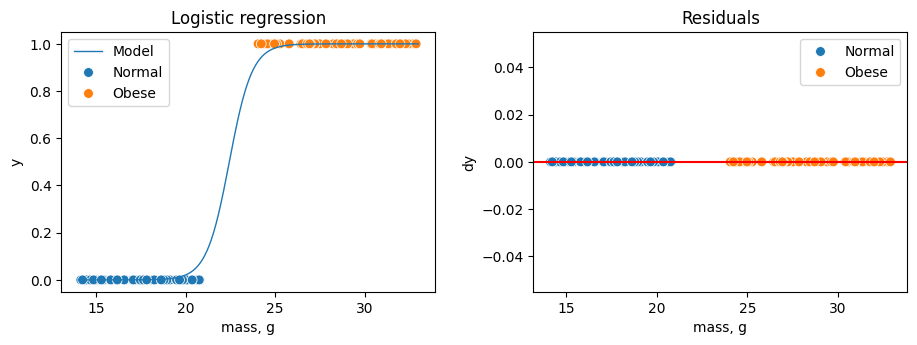

In [ ]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(x, y)

y_pred = classifier.predict(x)
y_model = classifier.predict_proba(x_model)

visual_1d_linear_model(x, y, y_pred, x_model, y_model[:, 1], "Logistic regression")

## Многоклассовая классификация




Рассмотрим задачу многоглассовой классификации на примере картинок, например, для датасета CIFAR-10. У нас есть входное изображение, и мы хотим получить на выходе 10 чисел, обозначающих уверенность модели в принадлежности изображения к конкретному классу. При этом мы знаем, что наши данные устроенны так, что одно изображение может относиться только к одному классу.

<img src ="https://ml.gan4x4.ru/msu/dev-2.1/L02/out/img_to_function_get_scores.png" width="600">







Мы можем считать по logit-у для каждого класса:
$$\begin{matrix} s_1 = (\vec{w_1}, \vec{x}) + b_1\\ s_2 = (\vec{w_2}, \vec{x}) + b_2\\ ... \\ s_n = (\vec{w_n}, \vec{x}) + b_n \end{matrix}$$

Также мы можем записать формулы выше в виде матричного перемножения. Для этого нужно преобразовать матрицу пикселей в вектор признаков (просто вытянув массив в вектор), а строки с весами модели — в матрицу.

<img src ="https://ml.gan4x4.ru/msu/dev-2.1/L02/out/scalar_product_add_bias.png" width="750">

В таком случае для непересекающихся классов результатом классификации будет класс, соответствующий наибольшему logit-у.

В дальнейшем мы будем проходить нейронные сети, которые работают очень похоже.



### SoftMax

[[video] 📺 Объяснение SoftMax от StatQuest](https://www.youtube.com/watch?v=KpKog-L9veg)

Предположим, что наша модель выдала следующие значения logit-ов.

In [ ]:
# fmt: off
logits = [[5.1,    # cat
           3.2,    # car
          -1.7]]   # frog
# fmt: on

Тогда, чтобы узнать, какой класс наша сеть предсказала, мы могли бы просто взять `argmax` от наших `logits`:

In [ ]:
import numpy as np

print("Predicted class = %i (Cat)" % (np.argmax(logits, axis=1).squeeze()))

Predicted class = 0 (Cat)


От argmax нельзя посчитать градиент, так как производная от константы равна 0. Соответственно, если бы мы вставили производную от argmax в градиентный спуск, мы бы получили везде нули, и наша модель бы вообще ничему не научилась.

Кроме того, мы бы хотели получить не logit’ы, а настоящую вероятность $p$ на выходе модели. Да еще и таким образом, чтобы от наших вероятностей можно было посчитать градиент. Для этого мы можем применить к нашим логитам функцию **SoftMax**:
$$\large p(y=k|x=x_i) = \frac{e^{s_k(x_i)}}{\sum_{j=1}^ne^{s_j(x_i)}},$$

где $x_i$ — набор признаков, характеризующий один объект из выборки,
$s_j(x_i)$ — logit для j-го класса для объекта $x_i$.


Функция **SoftMax** вводится на основании двух свойств вероятностей:

1. **Вероятности всегда неотрицательны**. Отобразим наши logit’ы на значения $[0, +∞)$.

> Для этого возведем **экспоненту** (число Эйлера $e=2.71828$) **в степень логита**. В результате мы получим вектор гарантированно неотрицательных чисел (положительное число, возведенное в степень, даже отрицательную, даст положительное значение).

2. Классы не пересекаются, **сумма вероятностей** по всем классам **равна единице**.

>  Мы должны их **нормализовать**, то есть поделить на сумму.

Получаются числа, которые можно интерпретировать, как **вероятности**.

<img src ="https://ml.gan4x4.ru/msu/dev-2.1/L02/out/linear_classifier_softmax.png" width="1000">



$\displaystyle \text{SoftMax}_\text{кошка} = \frac{e^{5.1}}{e^{5.1} + e^{3.2} + e^{-1.7}}$

In [ ]:
def softmax(logits):
    return np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)


print(f"logits: {logits},")
print(f"probabilities: {softmax(logits)}")
print("Sum = %.2f" % np.sum(softmax(logits)))

logits: [[5.1, 3.2, -1.7]],
probabilities: [[0.86904954 0.12998254 0.00096793]]
Sum = 1.00


Можно заметить, что SoftMax никоим образом не поменял порядок значений: самому большому logit'у соответствует самая большая вероятность, а самому маленькому, соответственно, самая маленькая.

#### Практическое вычисление SoftMax

При вычислении экспоненты от выходов модели могут получиться очень большие числа в силу очень высокой скорости роста экспоненты. Этот факт необходимо учитывать, чтобы вычисления SoftMax были численно стабильны:

In [ ]:
from warnings import simplefilter

simplefilter("ignore", category=RuntimeWarning)

f = np.array([[123, 456, 789]])
p = softmax(f)
print(f"logits = {f},\nprobabilities = {p}")

logits = [[123 456 789]],
probabilities = [[ 0.  0. nan]]


Чтобы регуляризовать вычисление, нам следует предварительно упростить возникающую в вычислении дробь. Для этого мы можем вычесть из каждого $s_i$ положительную константу, чтобы уменьшить значения экспонент. В качестве константы можно выбрать максимальный элемент этого вектора, тогда у нас гарантированно не будет очень больших чисел, и такой способ будет работать более стабильно.

$$\large M = \max_j s_{j}(x_i),$$

$$\large s^\text{new}_{j}(x_i)  = s_{j}(x_i) - M,$$

$$\large \dfrac {e^{s^\text{new}_{k}(x_i)}} {\sum_j e^{s^{new}_{j}(x_i)}}  = \dfrac {e^{s_{k}(x_i) - M }} {\sum_j e^{s_{j}(x_i) - M }} = \dfrac {e^{s_{k}(x_i)}e ^ {-M}} {\sum_j e^{s_{j}(x_i)} e ^ {-M}} = \dfrac {e ^ {-M} e^{s_{k}(x_i)}} {e ^ {-M} \sum_j e^{s_{j}(x_i)} } = \dfrac { e^{s_{k}(x_i)}} { \sum_j e^{s_{j}(x_i)} },$$

где $x_i$ — набор признаков, характеризующий один объект из выборки,
$s_j(x_i)$ — logit для $j$-го класса для объекта $x_i$.


In [ ]:
def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)


f = np.array([[123, 456, 789]])

p = softmax(f)
print(f"logits = {f},\nprobabilities = {p}")

logits = [[123 456 789]],
probabilities = [[5.75274406e-290 2.39848787e-145 1.00000000e+000]]


**Замечание:** В реальных вычислениях, SoftMax часто объединяют с Cross-Entropy Loss, это позволяет уменьшить количество операций exp и log.

## Cross-Entropy loss

Итоговая последовательность преобразований будет выглядеть так:

<img src ="https://ml.gan4x4.ru/msu/dev-2.1/L02/out/linear_model_probability_pipeline.png" width="1000">

Будем использовать log loss. Запишем функцию ошибок, как:

$$\text{Loss} = - \log(p^y_\text{pred}),$$

где $p^y_\text{pred}$ — предсказанная вероятность для истиного класса. Минус нужен, т.к. $-\log(0) = ∞$.

Вернемся к задаче классификации картинок.

<img src ="https://ml.gan4x4.ru/msu/dev-2.1/L02/out/logits_to_scores_to_probabilitys.png" width="900">

На картинке на входе был изображен кот. Мы можем преобразовать метки классов следующим образом:

$$ y → p_\text{true} $$

$$ p_\text{true_i}= \begin{cases} 1 & \text{для i=k, где k - номер истинного класса}, \\0 & \text{для любого } i\neq k.
 \end{cases}$$
Таким образом,
$$ y → p_\text{true} = [[1, 0, 0]]$$


В таком случае функция ошибки выше может быть записанна как [кросс-энтропия 📚[wiki]](https://en.wikipedia.org/wiki/Cross-entropy):
$$\text{Loss} = - \log(p^y_\text{true})= H(p_\text{pred}||p_\text{true})= - \sum^C_{i=1}p_\text{true_i}\cdot \log(p_\text{pred_i}) = -1⋅\log{0.87}-0\cdot\log{0.13}-0\cdot\log{0.001} = - \log(p_\text{cat}) = - \log{0.87} \approx0.14$$

Реализуем это в коде:

In [ ]:
def cross_entropy_loss(pred_prob, true_prob):
    # warning: this code does not take into account the possibility that
    # pred_prob could be equal to zero: add epsilon = 1e-9 to fix it
    return np.sum(-true_prob * np.log(pred_prob)) / pred_prob.shape[0]


# 3 classes 2 items
# fmt: off
logits = np.array([
    [5.1, 3.2, -1.7], # one item
  # [2.1, 6.3,  1.5],  # second item
])
# fmt: on

print(f"Logits = \n{logits}\n")

pred_prob = softmax(logits)
print(f"Predicted Probabilities = \n{pred_prob}\n")

# 3 classes 2 items
# fmt: off
true_prob = np.array([
    [1.0, 0.0, 0.0],  # one item
  # [0.0, 1.0, 0.0],  # second item
])
# fmt: on

print(f"True Probabilities = \n{true_prob}\n")

print(f"Cross-entropy loss = {cross_entropy_loss(pred_prob, true_prob):.3f}")

Logits = 
[[ 5.1  3.2 -1.7]]

Predicted Probabilities = 
[[0.86904954 0.12998254 0.00096793]]

True Probabilities = 
[[1. 0. 0.]]

Cross-entropy loss = 0.140


### Математический смысл

**Кросс-энтропия** имеет глубокий математический смысл в теории информации и статистике. Она связана с [энтропией 📚[wiki]](https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%8D%D0%BD%D1%82%D1%80%D0%BE%D0%BF%D0%B8%D1%8F) $H(P)$ и  [расстоянием Кульбака — Лейблера 📚[wiki]](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%9A%D1%83%D0%BB%D1%8C%D0%B1%D0%B0%D0%BA%D0%B0_%E2%80%94_%D0%9B%D0%B5%D0%B9%D0%B1%D0%BB%D0%B5%D1%80%D0%B0) $D_{KL}(P||Q)$:


$$H(P||Q) = D_{KL}(P||Q) + H(P)$$


Подробнее об этом можно почитать тут:

[[colab] 🥨 Cross-entropy](https://colab.research.google.com/drive/1DFhT24njhb4LA2g6iJtl2diH-YPtD2Z4
)

### Binary Cross-Entropy

Для задачи **бинарной классификации** или **multi-label классификации** (одному объекту может соответствовать несколько классов) можно использовать модификацию cross-entropy, которую называют **binary cross-entropy**:

$$\text{Loss} =  - \sum^C_{i=1}(p_\text{true_i}\cdot \log(p_\text{pred_i}) + (1-p_\text{true_i})\cdot \log(1-p_\text{pred_i}))$$

В этом случае порог вероятности 0.5 может быть не оптимальным для определения класса. Подробнее про выбор оптимального порога рекомендуем почитать:
* [[blog] ✏️ A Gentle Introduction to Threshold-Moving for Imbalanced Classification](https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/)

### Градиент функции потерь. Кросс-энтропия




Итоговая последовательность преобразований будет выглядеть так:

<img src ="https://ml.gan4x4.ru/msu/dev-2.1/L02/out/linear_model_probability_pipeline.png" width="1000">

[[blog] ✏️ Cross-Entropy Loss](https://wandb.ai/wandb_fc/russian/reports/---VmlldzoxNDI4NjAw)

Посчитаем производную от функции ошибок. Функция ошибок:

$$ L = - \sum_i p_\text{true_i} \log p_\text{pred_i} = -\sum_i p_\text{true_i} \log(\dfrac {e^{s_i}} {\sum_j e^{s_j}}),$$

где $s_i$ — это логиты классов, получаемые из линейной модели:

$$s_i = w_i x$$

Для расчета градиента будем использовать chain rule:

$$ \dfrac {\partial L} {\partial w_i} = \dfrac {\partial L} {\partial s_i} \dfrac {\partial s_i} {\partial w_i} $$

Градиент логитов по весам:

$$\dfrac {\partial s_i} {\partial w_i} = x$$

У нас только одна истинная метка класса $p_\text{true_k} = 1$, для $i\neq k$ $p_\text{true_k}=0$

$$ L = -1⋅ \log p_\text{pred_k} = - \log(\dfrac {e^{s_k}} {\sum_j e^{s_{j}}})$$



У нас два случая:
1. **Производная по истинному логиту** (значение логита входит в числитель и знаменатель дроби).
2. **Производная по остальным логитам** (значение логита входит только в знаменатель дроби).

Начнем с истинного логита:
1. Производная по $s_{k}$. Вынесем минус, чтобы не потерять:

$$ -L = \log(\dfrac {e^{s_{k}}} {\sum_j e^{s_{j}}}) = \log e^{s_{k}} - \log  \sum_j e^{s_{j}}  = s_{k} - \log  \sum_j e^{s_{j}}$$

$$\dfrac {\partial -L} {\partial s_{k}} = 1 - \dfrac 1 {\sum_j e^{s_{j}}} \cdot \dfrac {\partial {\sum_j e^{s_{j}}}} {\partial s_{k}} = 1 - \dfrac 1 {\sum_j e^{s_{j}}} \cdot \dfrac {\partial e^{s_{k}}} {\partial s_{k}} = 1 - \dfrac {e^{s_{k}}} {\sum_j e^{s_{j}}} = 1 - p_k$$

Вспомним про минус:

$$\dfrac {\partial L} {\partial s_{j}} = p_k - 1 $$

2. Для остальных логитов $i \neq k$. Вынесем минус, чтобы не потерять:

$$ -L = \log(\dfrac {e^{s_{i}}} {\sum_j e^{s_{j}}}) = \log e^{s_{k}} - \log  \sum_j e^{s_{j}}  = s_{k} - \log  \sum_j e^{s_{j}}$$

$$\dfrac {\partial -L} {\partial s_{i}} = - \dfrac 1 {\sum_j e^{s_{j}}} \cdot \dfrac {\partial {\sum_j e^{s_{j}}}} {\partial s_{i}} =  \dfrac 1 {\sum_j e^{s_{i}}} \cdot \dfrac {\partial e^{s_{i}}} {\partial s_{i}} = \dfrac {e^{s_{i}}} {\sum_j e^{s_{j}}} = - p_i$$

Вспомним про минус:

$$\dfrac {\partial L} {\partial s_{j}} = p_i $$

Получаем:
$$ \dfrac {\partial L} {\partial s_{i}}  =  \begin{cases} p_i - 1 & \text{для i=k, где k - номер истинного класса}, \\p_i & \text{для любого } i\neq k.
 \end{cases} $$

Применим **chain rule**:

$$ \dfrac {\partial L} {\partial w_i}  = \dfrac {\partial L} {\partial s_{i}} \dfrac {\partial s_{i}} {\partial w_i}  =  \begin{cases}(p_i - 1)x & \text{для i=k, где k - номер истинного класса}, \\p_ix & \text{для любого } i\neq k.
\end{cases} $$

В коде это будет выглядеть вот так:

In [ ]:
# Input batch of 2 vector with 4 elements
# fmt: off
x = np.array([[1,  2, 3, 4],
              [1, -2, 0, 0]])
# fmt: on

# Weights
W = np.random.randn(3, 4)  # 3 class

# model output
logits = x.dot(W.T)
print("Scores(Logits) \n", logits, "\n")

# Probabilities
probs = softmax(logits)  # defined before
print("Probs \n", probs, "\n")

# Ground true classes
y = [0, 1]

# Derivative
dl_ds = probs.copy()
dl_ds[np.arange(len(y)), y] += -1  # substract one from true class prob
dW = x.T.dot(dl_ds)  # dot product with input

print("Grads dL/dW \n", dW)  # have same shape as W

Scores(Logits) 
 [[-8.18596096  2.85515452  2.2492031 ]
 [ 0.68506177 -0.93389703  0.19502048]] 

Probs 
 [[1.03708766e-05 6.47010003e-01 3.52979626e-01]
 [5.52270784e-01 1.09407525e-01 3.38321691e-01]] 

Grads dL/dW 
 [[-0.44771885 -0.24358247  0.69130132]
 [-3.10452083  3.07520495  0.02931587]
 [-2.99996889  1.94103001  1.05893888]
 [-3.99995852  2.58804001  1.41191851]]
